# **Generalization and Legos**

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

- Last time, we tried a somewhate naive approach to machine learning - memorizing the examples in our training data. 
- This appraoch performed suspiciously well on our training data.

![](../graphics/table_two-01.png)

---

- So...what's the problem here?
- Did you figure it out?
- Why can't we trust these numbers? 
- Because....

![](../graphics/memorization_not_learning-01.png)

- This is as true for humans as it is for machines. I could go on about this point for a while, but briefly:
- On the Human side - human learning is not memorization, and if you ever feel like you have to memorize something to do well in this class, then I haven't done my job well
- On the machine side - all the time I hear people say things like **"oh, the ML algorithm just hasn't seen this before"** - this oversimplifies what's going on here.
- While it's true that ML algorithms will only perform well on the same "world of examples" or "distribution" they we're trained on - it's not just a matter of showing the ML algorithm "all the examples" as we'll see shortly - this is intractible. 
- **Learning is about generalizing**.

# **So, what should we do about it?**

- Well, for starters, it would be nice to know if our algorithm learned anything. 
- A great way to do this is to test our algorithm on **examples that it hasn't seen before**. 
- Let's do it.

In [1]:
%pylab inline
import pickle, sys

sys.path.append('../util')
from data_handling import extractExamplesFromList, findUniqueRowsAndCount
from viz import showMatches, bw, rw, rwb
from data_handling import extractFeatures
from image import makeGrayScale

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load data:
with open('../data/training_data.p', 'rb') as f:
    data = pickle.load(f)

In [3]:
#Let's pick a few examples to experiment with:
exampleIndices = [0, 1, 2]

#Examples we didn't train on:
testingExampleIndices = [3, 4]

- Let's have a look at these examples:

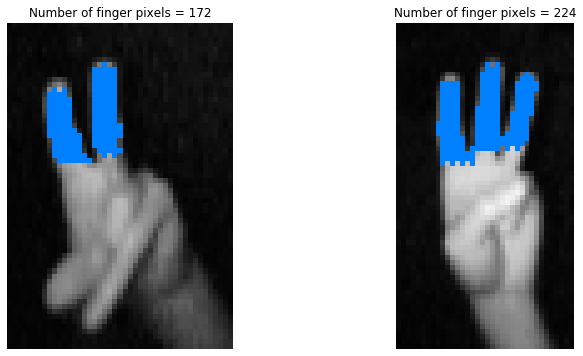

In [4]:
fig = figure(0, (12, 6))

for i in range(2):
    fig.add_subplot(1,2,i+1)
    imageDict = data[testingExampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    im = makeGrayScale(imageDict)
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im, interpolation = 'none')
    title('Number of finger pixels = ' + str(sum(y1==1)))
    axis('off')

And now, let's run our "memorization algorithm" from last time. Now, to do this, we need to extract the examples from our training data again.

In [5]:
# Extract 9x9 example grids and correct labels from our 3 images:
examples = [data[index] for index in exampleIndices]
X, y = extractExamplesFromList(examples, whichImage = 'image1bit', dist = 4)

#Find unique examples of fingers:
fingerExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(X[y==1])

#And let these example be our rules:
rules = fingerExamples.copy()

Alright, we can now test performance:

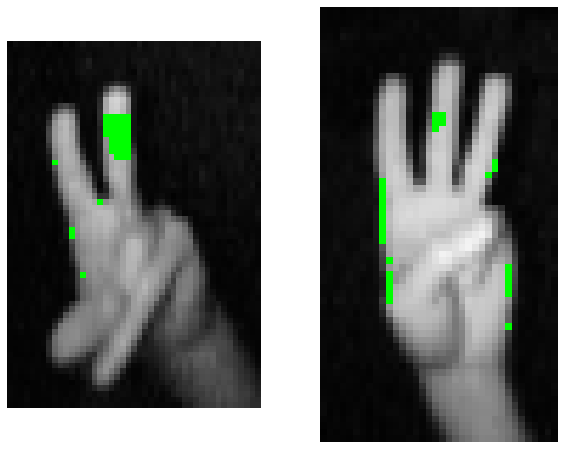

In [6]:
fig = figure(0, (10, 8))
showMatches(rules = rules, exampleIndices = testingExampleIndices, \
            data=data, fig=fig, verbose = False)

- What happened!? Where did all our pretty matches go?!?!
- Let's measure our new performance to see just how bad it is, but first let's take an educated guess:

![](../graphics/LTSQ4-01.png)

---

- Alright, let's actually measure it now.

In [7]:
testingExamples = [data[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, \
                                       whichImage = 'image1bit', dist = 4)

In [8]:
testX.shape

(5301, 81)

In [9]:
sum(testY==1)

396

In [10]:
# Search for matches to rules
matchingIndices = np.array([], dtype = 'int')
for rule in rules:
    difference = testX - rule
    mI = np.where(~difference.any(axis=1))[0]
    matchingIndices = np.concatenate((matchingIndices, mI))

#Make yHat vector, tells us which pixels our rules predict to be fingers.
yHat = np.zeros(testX.shape[0])
yHat[matchingIndices] = 1

#Count up False Negatives, False Positives, True Positives, and True Negatives
FN =  np.sum(np.logical_and(testY==1, yHat==0))
FP =  np.sum(np.logical_and(testY==0, yHat==1))
TP = np.sum(np.logical_and(testY==1, yHat==1))
TN = np.sum(np.logical_and(testY==0, yHat==0))
    
#make confusion matrix:
confusionMatrix = np.array([[TP, FN], [FP, TN]])

print(confusionMatrix)

[[  45  351]
 [  25 4880]]


![](../graphics/LTSQ5-01.png)

---

- Alright, so not so great. Let's look at all our results together:

![](../graphics/table_three-01.png)

- Our "memorization" appraoch performs worse than our knowledge engineering approach!
- Now, one possible reason that this could be happening is that we just haven't seen enough examples yet. 
- Instead of using 3 images of hands, let's try using 30. 

In [11]:
trainingExampleIndices = range(5, 35)
trainingExamples = [data[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, whichImage = 'image1bit', dist = 4)

In [12]:
#How many examples of not fingers do we have?
uniqueNonFingers, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(trainX[trainY==0])
uniqueNonFingers.shape

(17675, 81)

In [13]:
#Extract unique examples of fingers:
fingerExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(trainX[trainY==1])
rules = fingerExamples.copy()

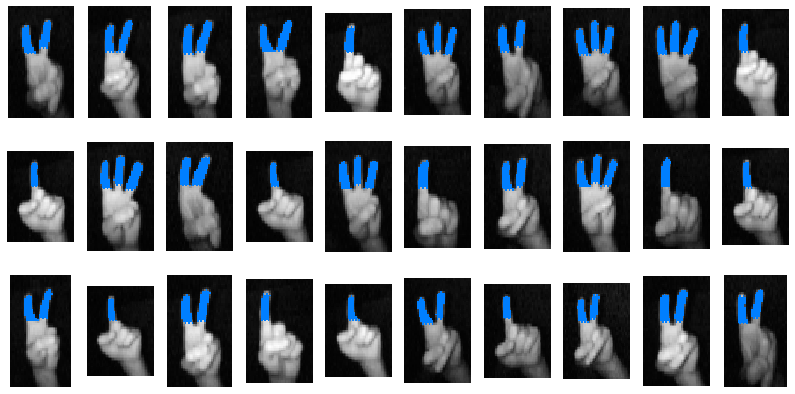

In [14]:
fig = figure(0, (14, 7))

for i in range(30):
    fig.add_subplot(3,10,i+1)
    imageDict = data[trainingExampleIndices[i]]
    
    X1, y1 = extractFeatures(imageDict, whichImage = 'image1bit', dist = 4)
    im = makeGrayScale(imageDict)
    
    yImage = y1.reshape(imageDict['boxHeight'], imageDict['boxWidth'])
    
    #Paint with matches:
    im[:,:,0][yImage==1] = 0
    im[:,:,1][yImage==1] = .5
    im[:,:,2][yImage==1] = 1
    
    imshow(im)
    axis('off')

How many rules (unique examples) do we have now?

In [15]:
rules.shape

(3035, 81)

And once again, let's test on examples not in our training set:

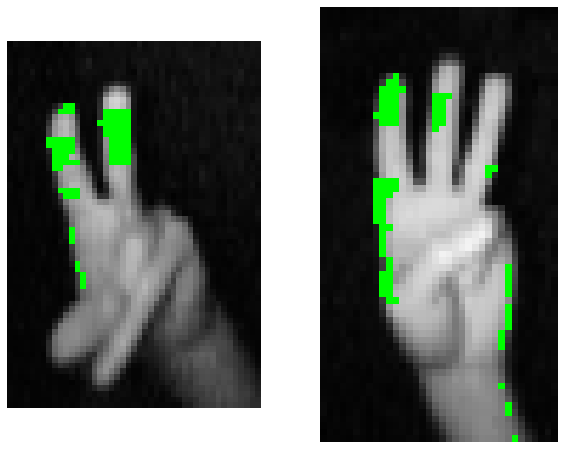

In [16]:
fig = figure(0, (10, 8))
showMatches(rules = rules, exampleIndices = testingExampleIndices, data=data, fig=fig, verbose = False)

In [17]:
# Search for matches to rules
matchingIndices = np.array([], dtype = 'int')
for rule in rules:
    difference = testX - rule
    mI = np.where(~difference.any(axis=1))[0]
    matchingIndices = np.concatenate((matchingIndices, mI))

#Make yHat vector, tells us which pixels our rules predict to be fingers.
yHat = np.zeros(testX.shape[0])
yHat[matchingIndices] = 1

#Count up False Negatives, False Positives, True Positives, and True Negatives
FN =  np.sum(np.logical_and(testY==1, yHat==0))
FP =  np.sum(np.logical_and(testY==0, yHat==1))
TP = np.sum(np.logical_and(testY==1, yHat==1))
TN = np.sum(np.logical_and(testY==0, yHat==0))
    
#make confusion matrix:
confusionMatrix = np.array([[TP, FN], [FP, TN]])

print(confusionMatrix)

[[ 113  283]
 [  68 4837]]


In [18]:
recall = float(TP)/(TP+FN)
precision = float(TP)/(TP+FP)

print(recall, precision)

0.28535353535353536 0.6243093922651933


-  a little better recall, but worse precision. 
- Increasing our number of examples by 10X had a very small impact
- Note the numbers in the table below are slightly different, they were generated from a slightly different training set of 30 examples.

![](../graphics/table_four-01.png)

- Note that our in sample preformance is still pretty good, but out of sample it quite bad.
- So, why did our memorization appraoch perform so poorly?
- At face value it doesn't seem so wild.
- One way to think about this problem is to consider the **universe of possible rules** we're considering here.

![](../graphics/universe_of_rules.png)

---

![](../graphics/LTSQ6-01.png)

---

- And a fun follow-up question:

![](../graphics/LTSQ7-01.png)

---

- That's way more than the number of atoms in the observable universe!
- Another way to think about why our memorization appraoch is struggling to actually learn is to consider the portion of all possible example we've seen. In our larger dataset, we end up with about 20k examples:

In [19]:
#How many unique examples do we have?
uniqueExamples, uniqueIndices, uniqueCounts = findUniqueRowsAndCount(trainX)
uniqueExamples.shape

(20555, 81)

...which might sounds like alot, but is only a **tiny** portion of all possible examples:

In [20]:
uniqueExamples.shape[0]/(2**81.)*100

8.501348745513742e-19

## we've seen $ \frac{20555}{2^{81}} = 0.000000000000000000850$ % of all possible examples. Sweet.

- The failure of our memorization appraoch to actually learn anything, and the staggaring variabity of our simple dataset, force us to address some tought questions:

![](../graphics/new_questions.png)

- To get to the bottom of this, let's simplify our problem one last time. 
- Instead of considering 9x9 grids of 1s and 0s, let's consider 2x2 grids. 
- Here the data will be arbitrary, it won't correspond to fingers or any real phonemena, this will help us think about the problem more clearly.

![](../graphics/toy_data_question_one.png)

- Just as before with our real finger examples, let's try to create a rule that matches our training data. 
- Can you think of a rule, in terms of our 4 variables $x_1, x_2, x_3, x_4$ that properly classifies our positive and negative examples?
- Using your rule, how would you classify our testing examples?
- Let's discuss a few example rules first, take a few minutes to think about it, and then discuss. 
- If time, we'll consider some other toy data.

---

![](../graphics/spacer_small.png)

![](../graphics/spacer_small.png)

---

- Now...for the harder question:

![](../graphics/toy_data_question_two.png)

You have two homework assignments: 
1. Really try to figure out the answer to this problem - I promise it's worthwhile.
2. Watch Learning to See, parts 6 and 7 (spoiler - the answer is in part 7).